На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:  

- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый  

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

### Задачи:
1. Выберать метод, который предположительно подойдет в первом вопросе.
2. Проверить, являются ли дисперсии внутри групп гомогенными.
3. Провести тест на нормальность распределения.
4. Сравнить средние в представленных группах.
5. Используя критерий Тьюки определить, между какими группами есть статистически значимые различия. 
6. Принять решение: какие картинки в итоге будем использовать?
7. Выбать метод для второго теста.
8. Визуализировать распределение `events` для контрольной и тестовой групп. 
9. Посмотреть на описательные статистики `events` в разбивке по группе и по сегменту пользователя. 
10. Выберать формулу для модели, проведите тест.

### Описание данных
[5_task_1](https://disk.yandex.ru/d/Lj5WClBbCt3fyw):  
`id` – id клиента в эксперименте  
`group` – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)  
`events` – сколько блюд суммарно было заказано за период    

[5_task_2](https://disk.yandex.ru/d/Vnlvg9uOrMVKhw):  
`id` – id клиента в эксперименте  
`segment` – сегмент (high/low)  
`group` – вид кнопки (control – старая версия, test – новая версия)  
`events` – сколько блюд суммарно было заказано за период  

In [3]:
import pandas as pd
from scipy import stats 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols 
from statsmodels.stats.anova import anova_lm 
import requests
from urllib.parse import urlencode

In [4]:
# скачиваем файлы данных в папку скрипта

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = ['https://disk.yandex.ru/d/Lj5WClBbCt3fyw', 
              'https://disk.yandex.ru/d/Vnlvg9uOrMVKhw']                # ссылки на данные

file_names = ['5_task_1.csv', 
             '5_task_2.csv']                                            # имена файлов

for i in range(2):
    # получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key[i]))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    with open(file_names[i], 'wb') as f:
        f.write(download_response.content)

In [5]:
task_1 = pd.read_csv('5_task_1.csv')
task_2 = pd.read_csv('5_task_2.csv')

### 1. Разрешение фотографий

In [6]:
task_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [7]:
task_1.group.value_counts()

B    10000
A    10000
C    10000
Name: group, dtype: int64

In [8]:
task_1.group.value_counts()

B    10000
A    10000
C    10000
Name: group, dtype: int64

A – прямоугольные 16:9  
B – квадратные  
C – прямоугольные 12:4  

In [9]:
group_a = task_1.query('group == "A"').events
group_b = task_1.query('group == "B"').events
group_c = task_1.query('group == "C"').events

Лучше всего для сравнения средних подойдёт статистический тест ANOVA

Проверим, являются ли дисперсии внутри групп гомогенными с помощью теста Левена.

In [10]:
stats.levene(group_a, 
             group_b,
             group_c)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

p-value > 0.05, не отклоняем нулевую гипотезу - дисперсии гомогенны.

Убедимся, что данные распределены нормально, применив тест Шапиро-Уилка,  normaltest, и qq-графики

In [11]:
# тест Шапиро-Уилка для группы А с ресемплированием
stats.shapiro(group_a.sample(n=1000, random_state=17))

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [12]:
# тест Шапиро-Уилка для группы B с ресемплированием
stats.shapiro(group_b.sample(n=1000, random_state=17))

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [13]:
# тест Шапиро-Уилка для группы С с ресемплированием
stats.shapiro(group_c.sample(n=1000, random_state=17))

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

Тесты Шапиро-Уилка показывают p-value > 0.05 для всех трёх групп, что позволяет нам не отклонять нулевую гипотезу.

In [14]:
# проверка на нормальность группы А с попощью normaltest
stats.normaltest(group_a)

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)

In [15]:
# проверка на нормальность группы B с попощью normaltest
stats.normaltest(group_b)

NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)

In [16]:
# проверка на нормальность группы C с попощью normaltest
stats.normaltest(group_c)

NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)

Аналогично normaltest показывает p-value > 0.05 для всех трёх групп, что подтверждает выводы сделанные по результатам теста Шапиро-Уилка.

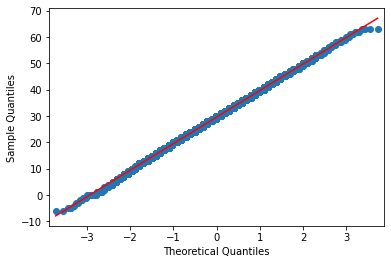

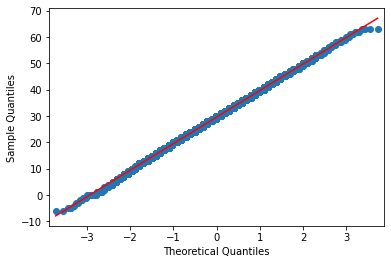

In [17]:
# qq-plot для группы А
sm.qqplot(group_a, line="r")

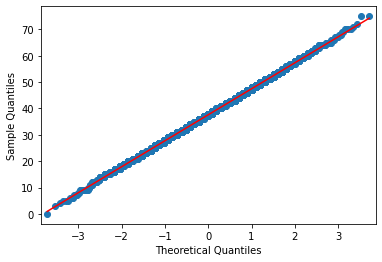

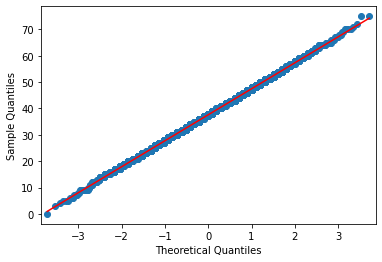

In [18]:
# qq-plot для группы B
sm.qqplot(group_b, line="r")

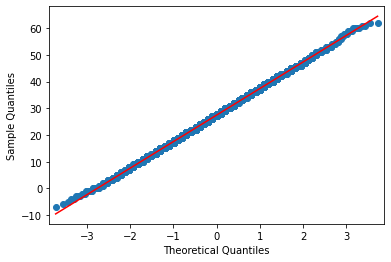

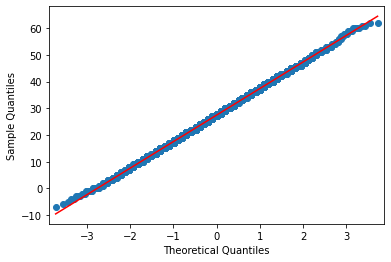

In [19]:
# qq-plot для группы C
sm.qqplot(group_c, line="r")

QQ-графики тоже показывают нормальное распределение для всех трёх групп

Проведём тест

In [20]:
stats.f_oneway(group_a, 
               group_b,
               group_c)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Согласно результатам теста, следует отклонить нулевую гипотезу о равенстве средних во всех группах. Т.е. как минимум в двух группах имеются различия.

 Воспользуемся критерием Тьюки и определим, между какими группами есть статистически значимые различия.

In [21]:
# критерий Тьюки для трёх групп
print(
    sm.stats
        .multicomp
        .pairwise_tukeyhsd(task_1.events, task_1.group)
)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


In [22]:
group_a.mean()

29.5796

In [23]:
group_b.mean()

37.6136

In [24]:
group_c.mean()

27.4703

Выбираем: B – Квадратные.

### 2. Формат кнопки

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [25]:
task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [26]:
len(task_2)

100000

In [27]:
task_2.group.value_counts()

control    50000
test       50000
Name: group, dtype: int64

In [28]:
task_2.segment.value_counts()

low     80000
high    20000
Name: segment, dtype: int64

In [29]:
test    = task_2.query('group == "test"').events
control = task_2.query('group == "control"').events

Визуализируем распределение events для контрольной и тестовой групп.

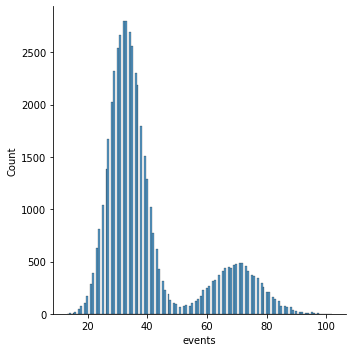

In [30]:
# распределение events для тестовой группы
sns.displot(test)

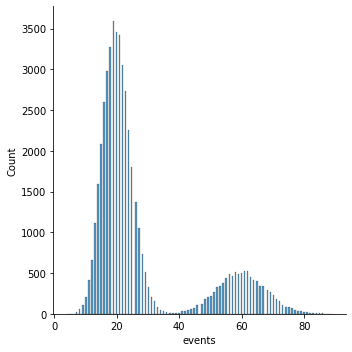

In [31]:
# распределение events для контрольной группы
sns.displot(control)

Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [32]:
(
    task_2
        .groupby(['group', 'segment'], as_index=False)
        .agg({'events': ['mean', 'median', 'std']})
)

group segment     events                 
                         mean median       std
0  control    high  59.970800   60.0  7.805347
1  control     low  20.031575   20.0  4.473576
2     test    high  69.938500   70.0  8.403974
3     test     low  33.025925   33.0  5.720845

In [33]:
formula = 'events ~ group + segment + group:segment' 
model = ols(formula = formula, data = task_2).fit() 
aov_table = anova_lm(model, typ=2)

In [34]:
aov_table

,sum_sq,df,F,PR(>F)
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group:segment,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [35]:
task_2['combination'] = task_2.group + '/' + task_2.segment

In [36]:
# критерий Тьюки для комбинаций групп и сегментов
print(
    sm.stats
        .multicomp
        .pairwise_tukeyhsd(task_2.events, task_2.combination)
)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2   meandiff p-adj  lower    upper   reject
----------------------------------------------------------------
control/high control/low -39.9392 0.001 -40.1073 -39.7711   True
control/high   test/high   9.9677 0.001   9.7551  10.1803   True
control/high    test/low -26.9449 0.001  -27.113 -26.7768   True
 control/low   test/high  49.9069 0.001  49.7388   50.075   True
 control/low    test/low  12.9944 0.001   12.888  13.1007   True
   test/high    test/low -36.9126 0.001 -37.0807 -36.7445   True
----------------------------------------------------------------


In [37]:
task_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test/high
1,96723,test,high,71.0,test/high
2,68719,test,high,80.0,test/high
3,50399,test,high,80.0,test/high
4,95613,test,high,78.0,test/high


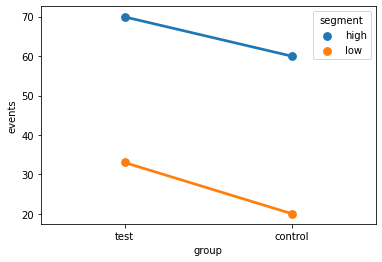

In [38]:
sns.pointplot(data=task_2, x='group', y='events', hue='segment')

Фактор `group` оказался значимым,  
фактор `segment` – значимым,   
их взаимодействие – значимо.   
Судя по графику, для всех групп среднее значение `events` увеличилось.   
Поэтому решение: ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ.